In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Load the training data
train_series = pd.read_csv('converted_train_series.csv')
train_events = pd.read_csv('train_events.csv')

# Load the test data
test_series = pd.read_csv('converted_test_series.csv')

Cell 1: Visualize the Distribution of Events

C:\Users\MAHAJAN\AppData\Local\Temp\ipykernel_19920\2493220835.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_events, x='event', palette='viridis')


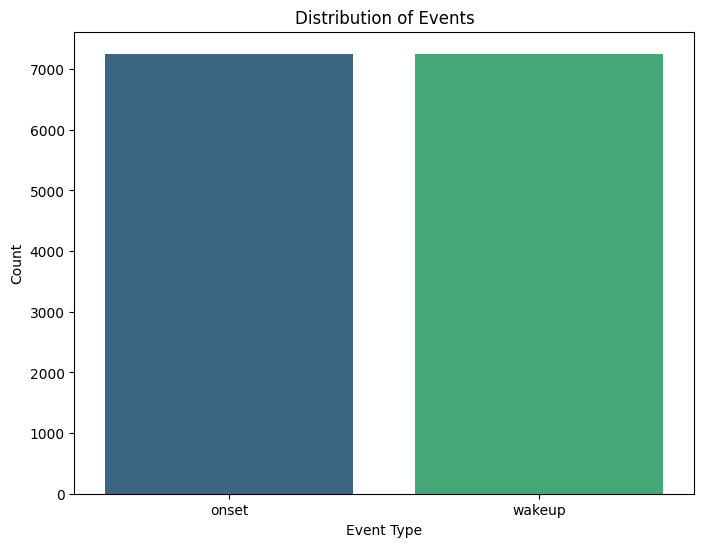

In [13]:
# Visualize the distribution of events in the training data
plt.figure(figsize=(8, 6))
sns.countplot(data=train_events, x='event', palette='viridis')
plt.title('Distribution of Events')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

Cell 2: Visualize Feature Distributions

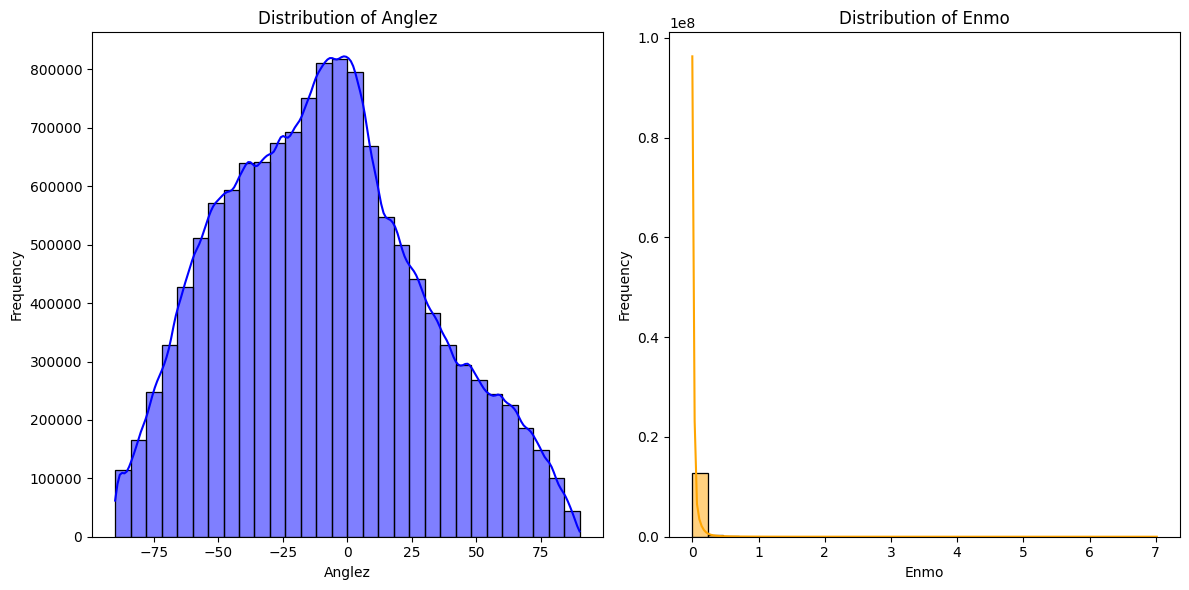

In [14]:
# Visualize the distribution of features
plt.figure(figsize=(12, 6))

# Anglez distribution
plt.subplot(1, 2, 1)
sns.histplot(train_series['anglez'], bins=30, kde=True, color='blue')
plt.title('Distribution of Anglez')
plt.xlabel('Anglez')
plt.ylabel('Frequency')

# Enmo distribution
plt.subplot(1, 2, 2)
sns.histplot(train_series['enmo'], bins=30, kde=True, color='orange')
plt.title('Distribution of Enmo')
plt.xlabel('Enmo')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

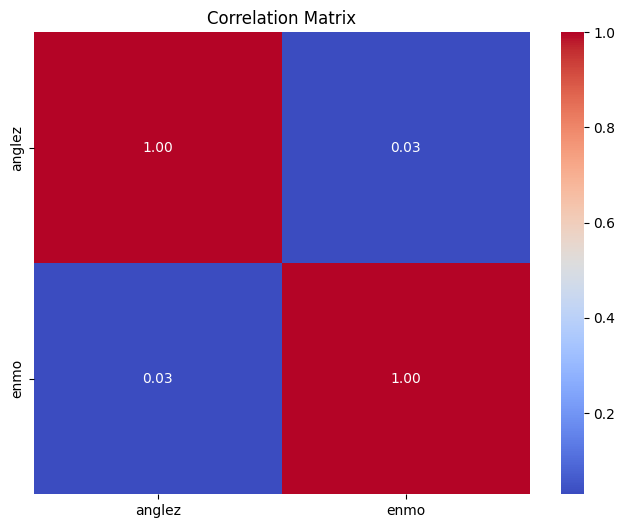

In [15]:
# Visualize the correlation matrix of features
plt.figure(figsize=(8, 6))
correlation_matrix = train_series[['anglez', 'enmo']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

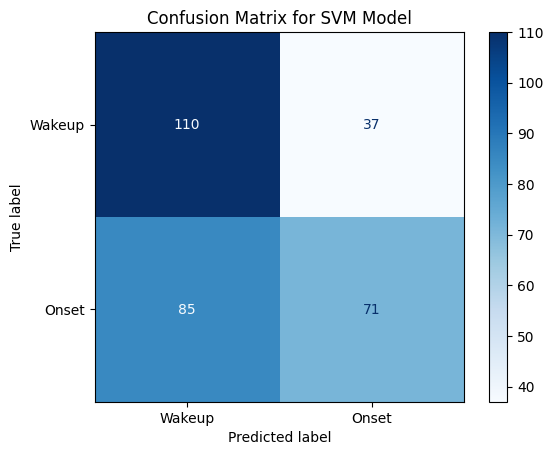

In [16]:
# Visualize the confusion matrix for the best model (SVM)
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming y_val and y_pred are defined for the best model
ConfusionMatrixDisplay.from_estimator(final_model, X_val, y_val, cmap='Blues', display_labels=['Wakeup', 'Onset'])
plt.title('Confusion Matrix for SVM Model')
plt.show()

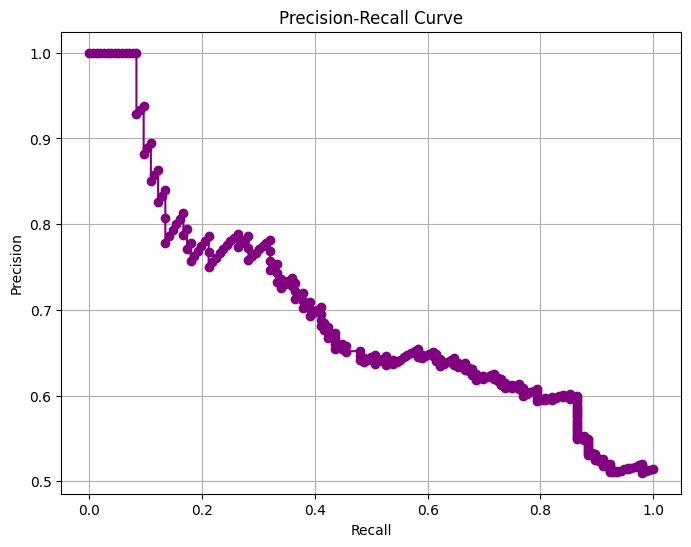

In [17]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
y_scores = final_model.predict_proba(X_val)[:, 1]  # Probability of the positive class
precision, recall, _ = precision_recall_curve(y_val, y_scores)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='o', color='purple')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

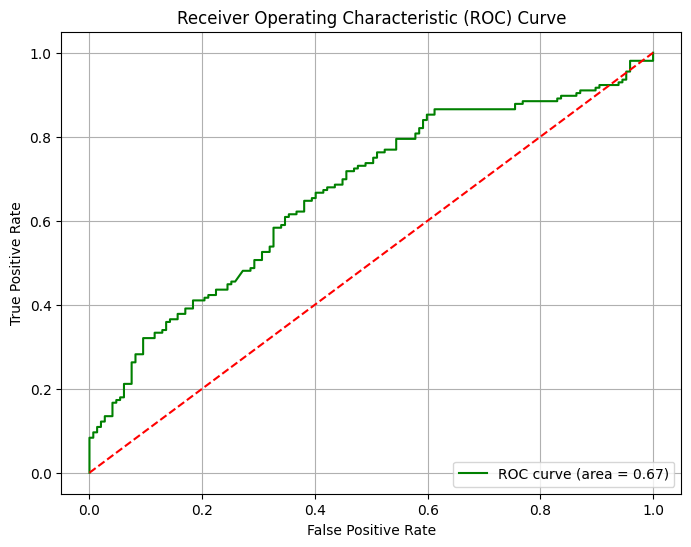

In [18]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [3]:
# Preprocessing
train_data = pd.merge(train_series, train_events, on=['series_id', 'step'], how='left')
train_data['event'].fillna('none', inplace=True)

# Create binary labels for the model
train_data['label'] = train_data['event'].apply(lambda x: 1 if x == 'onset' else (0 if x == 'wakeup' else -1))
train_data = train_data[train_data['label'] != -1]

# Feature selection
features = ['anglez', 'enmo']  # You can add more features if needed
X = train_data[features]
y = train_data['label']

C:\Users\MAHAJAN\AppData\Local\Temp\ipykernel_19920\3205938897.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['event'].fillna('none', inplace=True)


In [4]:
# Impute missing values and scale features
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

In [5]:
# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Select the best features
selector = SelectKBest(score_func=f_classif, k='all')  # Change 'all' to a specific number if needed
X_selected = selector.fit_transform(X_poly, y)

In [6]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [7]:
# Define models and their hyperparameter grids
models = {
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2']
    }),
    'Logistic Regression': (LogisticRegression(random_state=42), {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2']
    }),
    'SVM': (SVC(probability=True), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42), {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    })
}

best_models = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate

Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}


c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\P

Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best parameters for KNN: {'n_neighbors': 9, 'weights': 'uniform'}
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [8]:
# Evaluate all models
for model_name, model in best_models.items():
    y_pred = model.predict(X_val)
    print(f"\n{model_name} Classification Report:\n", classification_report(y_val, y_pred))
    print(f"{model_name} Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.65      0.59       147
           1       0.59      0.47      0.52       156

    accuracy                           0.56       303
   macro avg       0.56      0.56      0.56       303
weighted avg       0.56      0.56      0.55       303

Random Forest Confusion Matrix:
 [[96 51]
 [83 73]]

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.76      0.64       147
           1       0.64      0.42      0.51       156

    accuracy                           0.58       303
   macro avg       0.60      0.59      0.57       303
weighted avg       0.60      0.58      0.57       303

Logistic Regression Confusion Matrix:
 [[111  36]
 [ 91  65]]

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.75      0.64       147
          

In [9]:
# Choose the best model based on validation performance
final_model = best_models['SVM']  # Select SVM as the best model
print("Selected Final Model: SVM")

Selected Final Model: SVM


In [10]:
# Prepare the test features
X_test = test_series[['anglez', 'enmo']]
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)
X_test_poly = poly.transform(X_test_scaled)
X_test_selected = selector.transform(X_test_poly)

# Make predictions on the test data
test_predictions = final_model.predict(X_test_selected)
test_probabilities = final_model.predict_proba(X_test_selected)

In [11]:
# Prepare the submission DataFrame
submission = pd.DataFrame({
    'row_id': range(len(test_series)),
    'series_id': test_series['series_id'],
    'step': test_series['step'],
    'event': ['onset' if pred == 1 else 'wakeup' if pred == 0 else 'none' for pred in test_predictions],
    'score': [max(prob) for prob in test_probabilities]
})

# Save the submission file as submission_new.csv
submission.to_csv('submission_new.csv', index=False)
print("Submission file created: submission_new.csv")

Submission file created: submission_new.csv


Summary of Best Model (SVM)
Accuracy: 0.60
F1-Score (Macro Average): 0.59
Precision (Class 0): 0.56
Precision (Class 1): 0.66
Recall (Class 0): 0.75
Recall (Class 1): 0.46

In [19]:
# Load the submission file
submission_df = pd.read_csv('submission_new.csv')

C:\Users\MAHAJAN\AppData\Local\Temp\ipykernel_19920\2249707116.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=submission_df, x='event', palette='viridis')


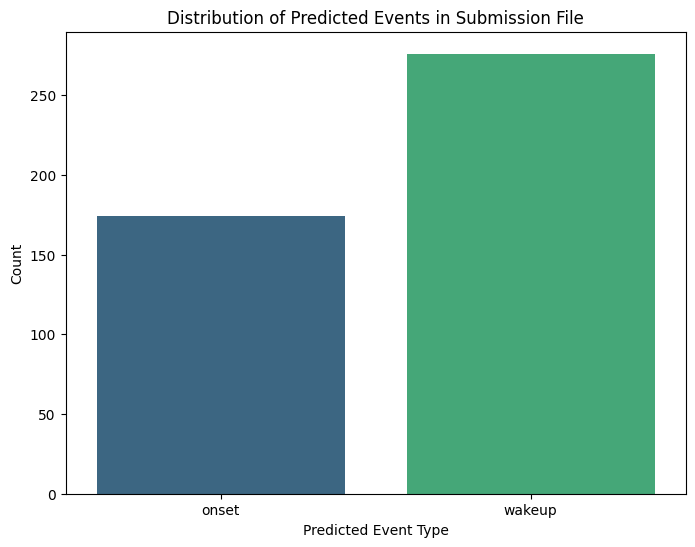

In [20]:
# Visualize the distribution of predicted events in the submission file
plt.figure(figsize=(8, 6))
sns.countplot(data=submission_df, x='event', palette='viridis')
plt.title('Distribution of Predicted Events in Submission File')
plt.xlabel('Predicted Event Type')
plt.ylabel('Count')
plt.show()

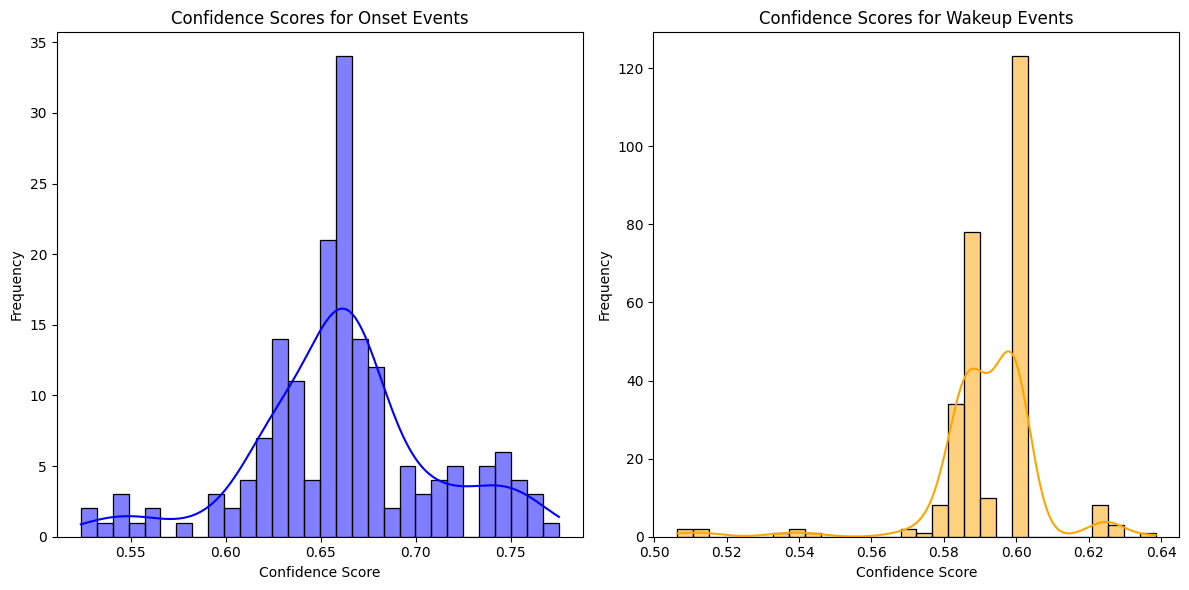

In [21]:
# Visualize the distribution of confidence scores for each event type
plt.figure(figsize=(12, 6))

# Confidence scores for 'onset'
plt.subplot(1, 2, 1)
sns.histplot(submission_df[submission_df['event'] == 'onset']['score'], bins=30, kde=True, color='blue')
plt.title('Confidence Scores for Onset Events')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')

# Confidence scores for 'wakeup'
plt.subplot(1, 2, 2)
sns.histplot(submission_df[submission_df['event'] == 'wakeup']['score'], bins=30, kde=True, color='orange')
plt.title('Confidence Scores for Wakeup Events')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()